# English Levels (sprint 1)

## General Characterstics of Data

In [0]:
!pip install readability

In [0]:
!pip install scikit-learn==0.22

In [0]:
import pandas as pd
import math
import re
import numpy as np
import sqlite3
import readability
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

Запишем данные из баз данных в датафреймы:

In [0]:
conn7 = sqlite3.connect("breakingnewsenglish.db")
df7 = pd.read_sql_query("select * from breakingnewsenglish", conn7)
conn7.close()
df7.head()

,publication_date,heading,article_text,level
0,2019-11-25,Apple removes customer reviews from online stores,Apple removed customer reviews from its online...,0
1,2019-11-21,Onion emergency in Bangladesh,Onions are important in Bangladesh. It is diff...,0
2,2019-11-17,Scientists warn insect apocalypse is coming,The falling numbers of insects is a big danger...,0
3,2019-11-13,Airlines create extra CO2 by 'fuel-tankering',A worker said airlines create extra CO2 by fue...,0
4,2019-11-09,Typhoon-damaged bullet trains scrapped in Japan,Ten of Japan's bullet trains were destroyed in...,0


In [0]:
conn3 = sqlite3.connect("newsinlevels.db")
df3 = pd.read_sql_query("select * from newsinlevels", conn3)
conn3.close()
df3.head()

,publication_date,heading,article_text,level
0,25-11-2019 15:00,Russia Returns Ships,"Last year, Russia takes three Ukrainian milita...",1
1,25-11-2019 07:00,Venice Underwater,"In Italy, there is a city called Venice. It li...",1
2,22-11-2019 15:00,Uber vs. New Jersey,The US state of New Jersey is not happy with U...,1
3,22-11-2019 07:00,School Safety Plan,"Last week, a student shoots other students. Th...",1
4,21-11-2019 15:00,Many Sides to Winston Churchill,"In World War II, Winston Churchill is a leader...",1


Посмотрим некоторые общие характеристики данных:

In [0]:
def general_characteristics(df_name, df, str2date):
    print(df_name)
    print('Количество текстов:', df.shape[0])
    print('Количество уровней:', df['level'].nunique())
    print('Количество текстов на каждый уровень:\n{}'.format(df['level'].value_counts().sort_index()))

    # отбросим часы и минуты: для нас они не так важны, к тому же в указании часов есть ошибки (29 часов?)
    df['publication_date'] = df['publication_date'].apply(lambda x: x.strip().split()[0])
 
    df = str2date(df)  # приводим дату из строкового формата в формат даты
    print('Время создания текстов: {} - {}\n'.format(min(df['publication_date']), max(df['publication_date'])))

In [0]:
def df7_str2date(x):
    df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y-%m-%d', errors='coerce')
    return df

In [0]:
def df3_str2date(df):
    df['publication_date'] = pd.to_datetime(df['publication_date'], format='%d-%m-%Y', errors='coerce')
    mask = df['publication_date'].isnull()
    df.loc[mask, 'publication_date'] = pd.to_datetime(df[mask]['publication_date'], format='%d-%m-%y')                                           
    return df

In [0]:
datasets = {'Dataset with 7 levels': [df7, df7_str2date], 'Dataset with 3 levels': [df3, df3_str2date]}

for df_name, df_function in datasets.items():
    df, str2date_function = df_function
    general_characteristics(df_name, df, str2date_function)

Dataset with 7 levels
Количество текстов: 2860
Количество уровней: 7
Количество текстов на каждый уровень:
0    408
1    408
2    414
3    402
4    406
5    407
6    415
Name: level, dtype: int64
Время создания текстов: 2014-10-20 00:00:00 - 2019-11-25 00:00:00

Dataset with 3 levels
Количество текстов: 7494
Количество уровней: 3
Количество текстов на каждый уровень:
1    2498
2    2500
3    2496
Name: level, dtype: int64
Время создания текстов: 2014-03-18 00:00:00 - 2019-11-25 00:00:00



- в первом датасете представлено 7 уровней владения языком, во втором - 3
- на каждый уровень приходится почти одинаковое количество текстов
- похожий промежуток создания текстов: 2014 - 2019 годы

Дальше функцией работы с датой мы пользоваться не будем, поэтому оставим в словаре датасетов только название датасета и сам датасет:

In [0]:
datasets = {df_name: df_function[0] for df_name, df_function in datasets.items()}

## Feature Engineering

### Readability

In [0]:
nlp = spacy.load("en_core_web_sm")
readability_indices = ['Kincaid', 'ARI', 'Coleman-Liau', 
                       'FleschReadingEase', 'GunningFogIndex', 'LIX',
                       'SMOGIndex', 'RIX', 'DaleChallIndex']

**Описание индексов читаемости текста:**

${\displaystyle {\text {Kincaid}}=0.39\times\frac{\text {words}}{\text {sentences}}+11.8\times\frac{\text {syllables}}{\text {words}}-15.59}$




${\displaystyle {\text ARI}=4.71\times {\frac {C}{W}}+0.5\times {\frac {W}{S}}-21.43}$, где

- ${\displaystyle C}$ — количество букв и цифр в тексте,
- ${\displaystyle W}$ — количество слов в тексте,
- ${\displaystyle S}$ — количество предложений в тексте.

${{\text {Coleman-Liau}}=0.0588\times{L}-0.296\times{S}-15.8}$, где

- ${L}$ — среднее количество букв на 100 слов,
- ${S}$ — среднее количество предложений на 100 слов.

${\displaystyle {\text {FleschReadingEase}}=206.835-1.015\times\frac{\text {words}}{\text {sentences}}-84.6\times\frac{\text {syllables}}{\text {words}}}$

${\displaystyle {\text{GunningFogIndex}}=0.4\times \left[{\frac {\text{words}}{\text{sentences}}}+\left(100\times {\frac {\text{hard words}}{\text{words}}}\right)\right]}$, где

${\text {hard words}}$ — количество слов с тремя или более слогами. К ним не относятся имена собственные и составные слова (compound words). Распространённые суффиксы (такие как -es, -ed, or -ing) не считаются как слоги.

${\displaystyle {\text {LIX}}={\frac {\text {words}}{\text {sentences}}}+{\frac {{\text {long words}}\times 100}{\text {words}}}}$, где

${\text {long words}}$ — количество длинных слов (более 6 букв)

${\displaystyle {\text {SMOGIndex}}=1.0430{\sqrt {{\text {hard words}}\times {\frac {30}{\text {sentences}}}}}\ +3.1291}$

${\displaystyle {\text{RIX}}={\frac {\mbox{long words}}{\mbox{sentences}}}}$, где

${\text {long words}}$ — количество длинных слов (более 6 букв)

${\text {DaleChallIndex}}=0.1579\left({\frac  {{\text {difficult words}}}{{\text {words}}}}\times 100\right)+0.0496\left({\frac  {{\text {words}}}{{\text{sentences}}}}\right)$

- Если доля ${\text {difficult words}}$ больше 5%, к этому значению нужно прибавить 3.6365.
- ${\text {difficult words}}$ — это слова, которые отсутствуют в списке знакомых слов и не являются формой знакомого слова.

Функция, которая преобразует текст в контейнер spacy:

In [0]:
def tokens(x):
    return nlp(x)

Функция, которая предобрабатывает текст так, что токены разделены пробелами, а предложения - переводом строки (именно такой формат требует библиотека readability):

In [0]:
def text_preprocessing(x):
    return '\n'.join([' '.join([token.text for token in sent]) for sent in x.sents])

Функция, вычисляющая индексы сложности для одного текста:

In [0]:
def readability_measures(x):
    return readability.getmeasures(x, lang='en')['readability grades']

Функция, строящая боксплоты:

In [0]:
def draw_boxplots(df, features, filename):
    n_features = len(features)
    n_columns = math.floor(math.sqrt(n_features))
    n_rows = math.ceil(n_features/n_columns)
    fig = plt.figure(figsize=(n_rows*4, n_columns*4))

    for n, i in enumerate(features):
        plt.subplot(n_columns, n_rows, n + 1)
        sns.boxplot(x='level', y=i, data=df)
        
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

Функция, которая строит тепловую карту:

In [0]:
def draw_heatmap(df, features, heatmap_data, filename):
    n_features = len(features)
    fig = plt.figure(figsize=(1.4*n_features, 1.1*n_features))
    sns.heatmap(heatmap_data, annot=True)

    # чтобы график не обрезался снизу и сверху
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

Функция, которая выполняет визуализацию результатов:
- строит боксплоты, показывающие значения признаков в зависимости от уровня
- строит тепловую карту для корелляций признаков между собой и с уровнем английского языка:

In [0]:
def visualize(df, df_name, features, features_name):
    draw_boxplots(df, features, ' '.join([df_name, features_name, 'boxplots.png']))

    features_for_heatmap = [*features, 'level']
    corr = df[features_for_heatmap].corr()
    draw_heatmap(df, features, corr, ' '.join([df_name, features_name, 'heatmap.png']))
    print(corr['level'].sort_values(ascending=False), '\n')

Функция, которая выполняет предобработку текстов, вычисляет индексы сложности и добавляет в датафрейм столбцы со значениями индексов сложности, а также проводит визуализацию:

In [0]:
def work_with_readability_measures(df_name, df):
    
    print(df_name)
    df['tokens'] = df['article_text'].apply(tokens)
    df['preprocessed_text'] = df['tokens'].apply(text_preprocessing)
    df['readability_measures'] = df['preprocessed_text'].apply(readability_measures)

    for i in readability_indices:
        df[i] = df['readability_measures'].apply(lambda x: x[i])

    df.drop(['readability_measures'], axis=1, inplace=True)
    visualize(df, df_name, readability_indices, 'readability')
    return df

Dataset with 7 levels


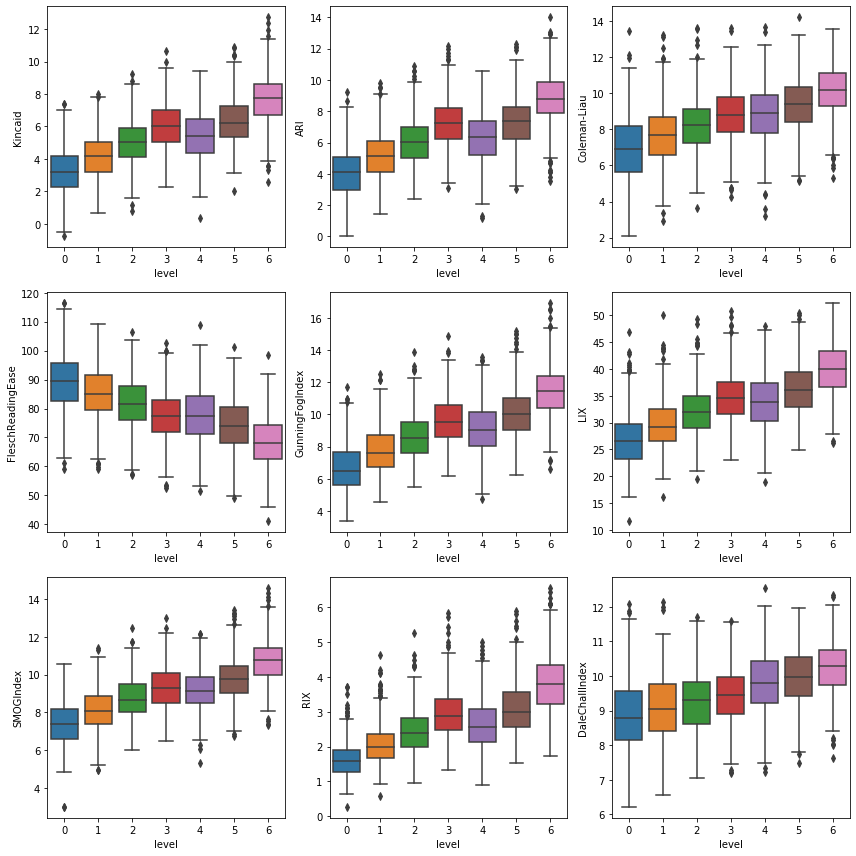

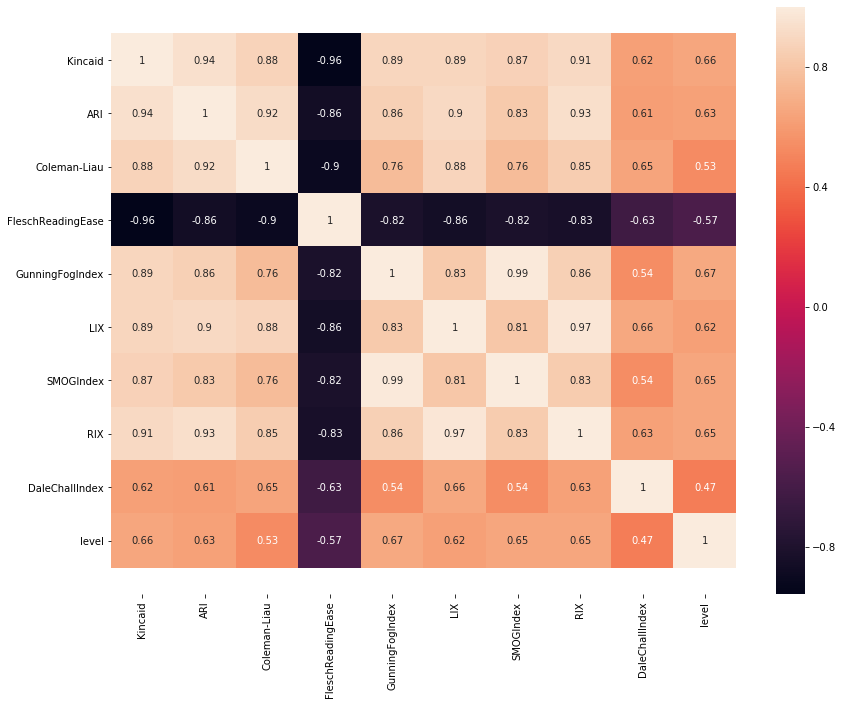

level                1.000000
GunningFogIndex      0.667906
Kincaid              0.655356
RIX                  0.654545
SMOGIndex            0.652854
ARI                  0.632708
LIX                  0.624546
Coleman-Liau         0.527727
DaleChallIndex       0.465412
FleschReadingEase   -0.574993
Name: level, dtype: float64 

Dataset with 3 levels


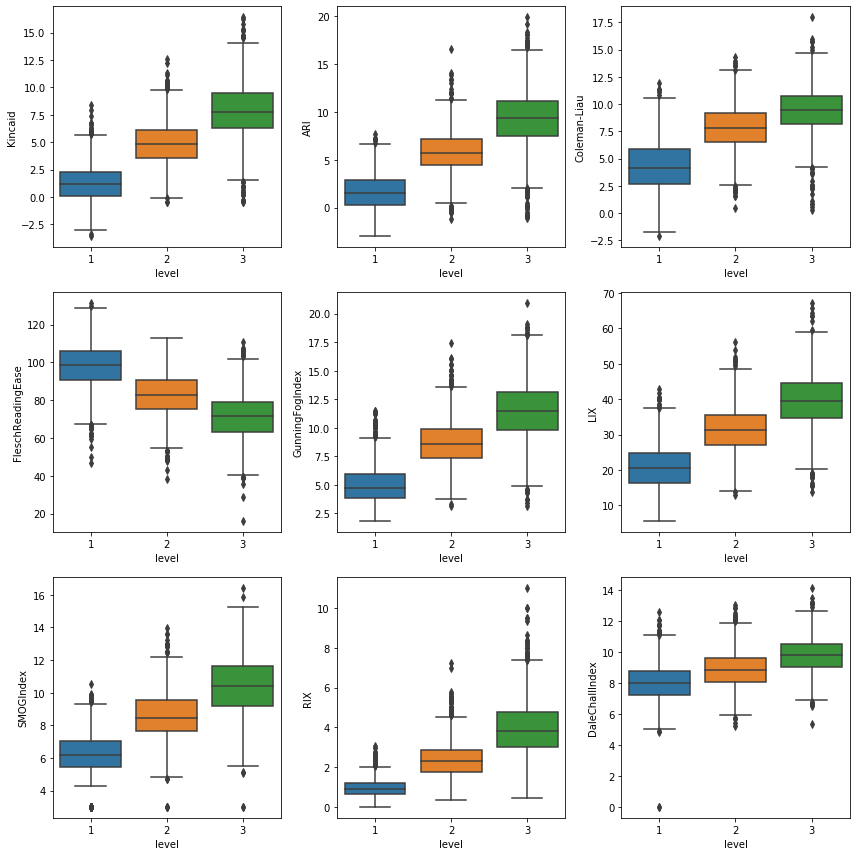

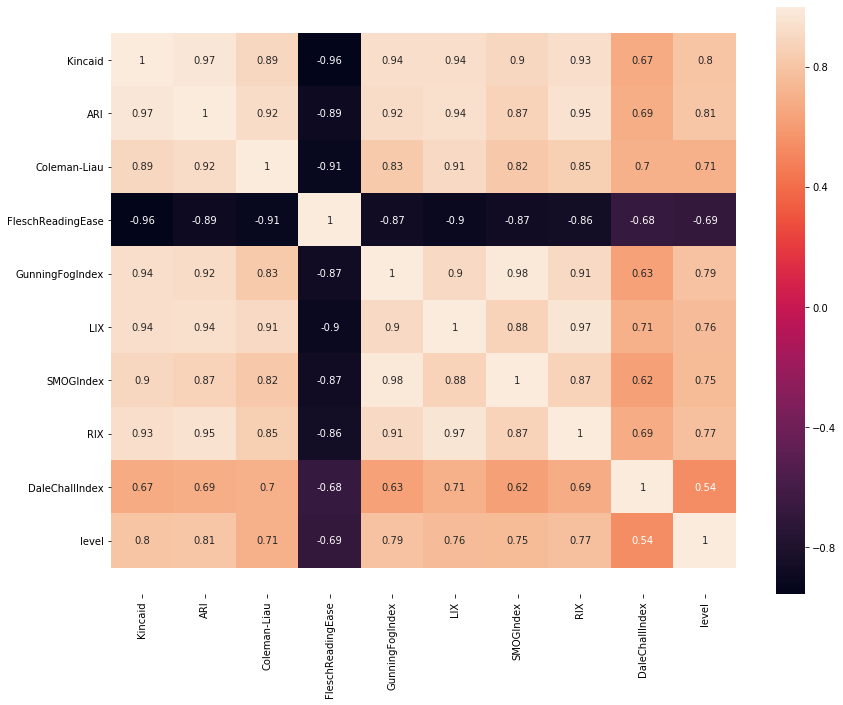

level                1.000000
ARI                  0.805787
Kincaid              0.801188
GunningFogIndex      0.793598
RIX                  0.772075
LIX                  0.761116
SMOGIndex            0.752768
Coleman-Liau         0.706765
DaleChallIndex       0.537900
FleschReadingEase   -0.693183
Name: level, dtype: float64 



In [0]:
for df_name, df in datasets.items():
    df = work_with_readability_measures(df_name, df)

- у обоих датасетов индексы читаемости текста имеют высокие корреляции с уровнем владения языком (FleschReadingEase имеет отрицательную корреляцию, остальные - положительную)
- у обоих датасетов индексы читаемости текста коррелируют между собой
- у датасета с тремя уровнями корреляции выше, чем с семи 
- у датасета с тремя уровнями, согласно некоторым индексам читаемости, третий уровень чуть сложнее, чем четвёртый

Индексы читаемости текста имеют ещё высокие корреляции с уровнем владения языком (FleschReadingEase имеет отрицательную корреляцию, остальные - положительную). Также индексы читаемости текста коррелируют между собой.

### Vocabulary

Функция, которая выбирает из текста только слова, выполняет лемматизацию них лемматизацию и приводит к нижнему регистру (местоимения не заменяются на лемму -PRON-):

In [0]:
def lemmas(x):
    lemmas = []
    for token in x:
        if token.is_alpha:
            if token.lemma_!='-PRON-':
                lemmas.append(token.lemma_.lower())
            else:
                lemmas.append(token.text.lower())
    return lemmas

Функция, которая находит отношение количества уникальных лемм ко всем леммам:

In [0]:
def unique_lemmas(x):
    return len(set([lemma for lemma in x]))/len(x)

Функция, которая находит отношение количества именованнных сущностей к количеству токенов:

In [0]:
def named_entities(x):
     return len(x.ents)/len(x)

Функция, которая находит отношение количества уникальных именованных сущностей к количеству всех именованных сущностей:

In [0]:
def unique_named_entities(x):
    return len(set([entity.text for entity in x.ents]))/len(x)

Dataset with 7 levels


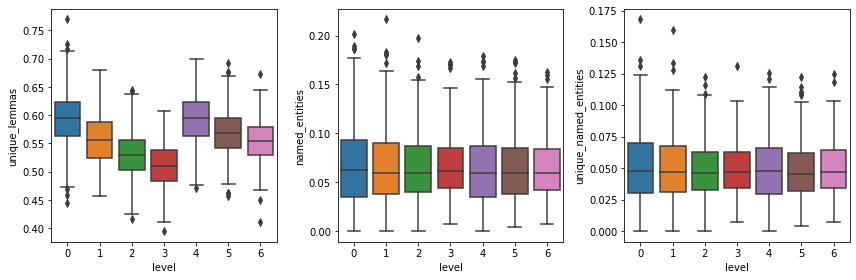

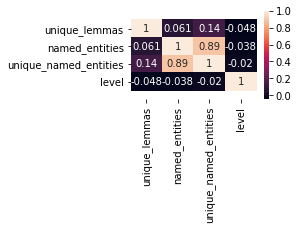

level                    1.000000
unique_named_entities   -0.019982
named_entities          -0.038375
unique_lemmas           -0.047985
Name: level, dtype: float64 

Dataset with 3 levels


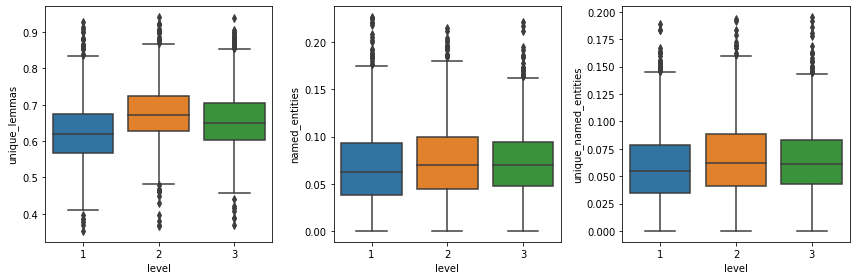

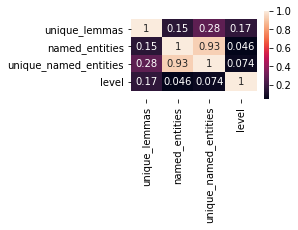

level                    1.000000
unique_lemmas            0.166344
unique_named_entities    0.074248
named_entities           0.045936
Name: level, dtype: float64 



In [0]:
unique_lemmas_ner = ['unique_lemmas', 'named_entities', 'unique_named_entities']

for df_name, df in datasets.items():
    print(df_name)
    df['lemmas'] = df['tokens'].apply(lemmas)
    df['unique_lemmas'] = df['lemmas'].apply(unique_lemmas)
    df['named_entities'] = df['tokens'].apply(named_entities)
    df['unique_named_entities'] = df['tokens'].apply(unique_named_entities)
    visualize(df, df_name, unique_lemmas_ner, 'unique lemmas&ner')

Функция для предобработки списка слов:
- берёт только слова, а не сочетания слов
- лемматизирует слова из списка

In [0]:
def preprocess_word_list(file_name):
    with open(file_name, encoding='utf-8') as f:
        words_from_list = f.read().split('\n')
        
    words_from_list = ' '.join([w for w in words_from_list if ' ' not in w])
    words_from_list = nlp(words_from_list)
    words_from_list = set(lemmas(words_from_list))
    return words_from_list

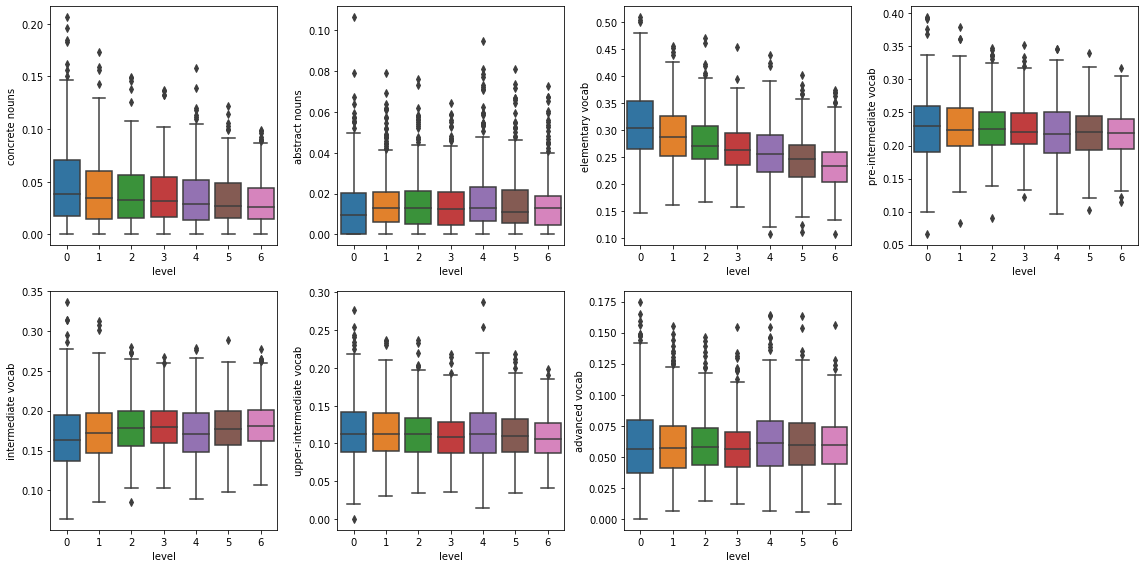

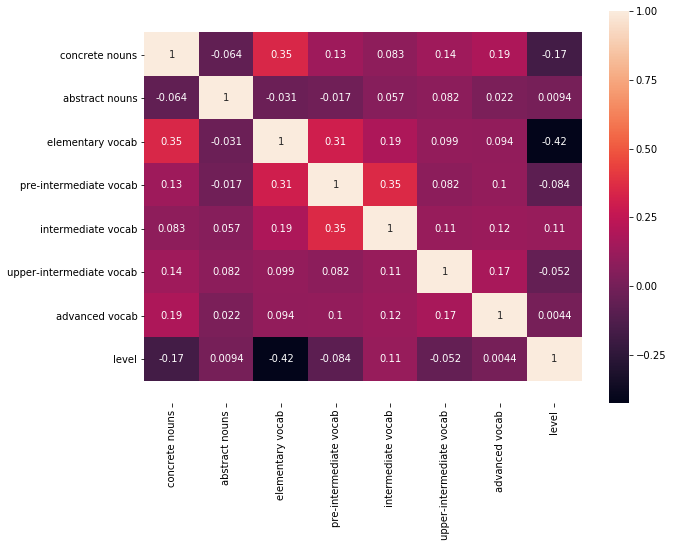

level                       1.000000
intermediate vocab          0.112695
abstract nouns              0.009447
advanced vocab              0.004440
upper-intermediate vocab   -0.052179
pre-intermediate vocab     -0.084112
concrete nouns             -0.168430
elementary vocab           -0.424030
Name: level, dtype: float64 



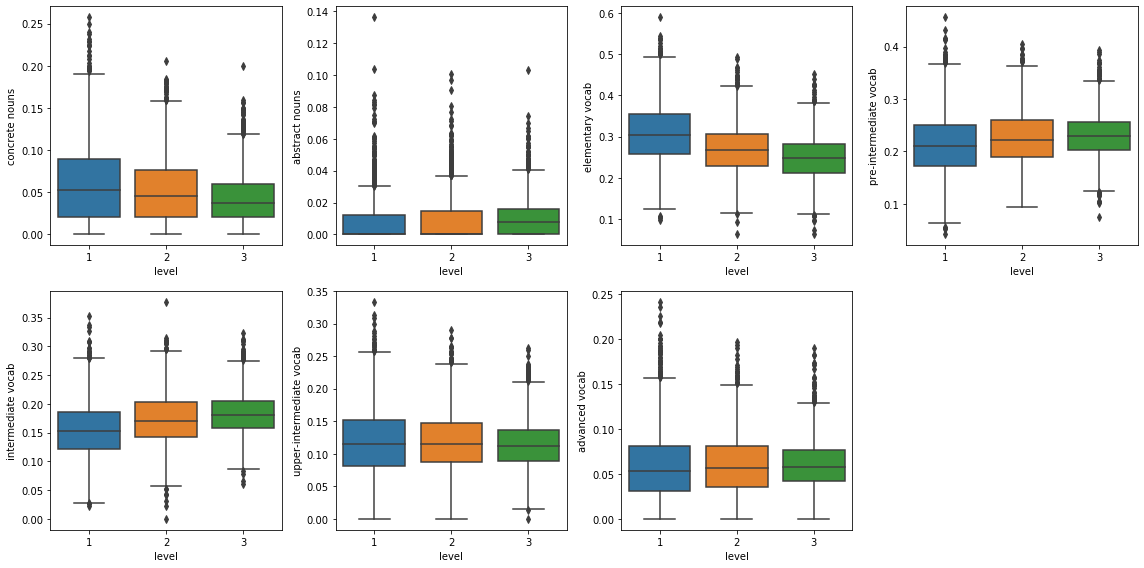

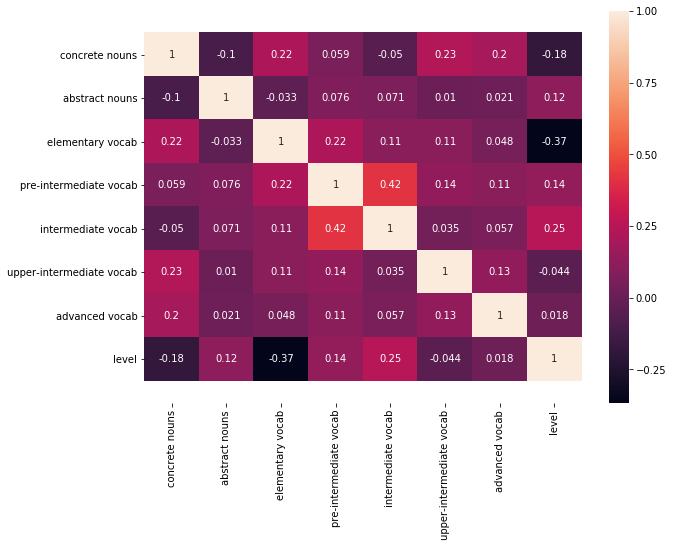

level                       1.000000
intermediate vocab          0.250375
pre-intermediate vocab      0.139088
abstract nouns              0.124129
advanced vocab              0.017859
upper-intermediate vocab   -0.043698
concrete nouns             -0.179780
elementary vocab           -0.366297
Name: level, dtype: float64 



In [0]:
word_lists = ['concrete nouns', 'abstract nouns', 
            'elementary vocab', 'pre-intermediate vocab', 'intermediate vocab',
            'upper-intermediate vocab', 'advanced vocab']
            
for list_name in word_lists:
    word_list = preprocess_word_list(list_name + '.txt')
        
    for df_name, df in datasets.items():
        df[list_name] = df['lemmas'].apply(lambda x: len([w for w in x if w in word_list])/len(x))

for df_name, df in datasets.items():
    visualize(df, df_name, word_lists, 'word lists')

- для обоих датасетов уровень слабее коррелирует с лексическими признаками, чем с индексами сложности
- для датасета с семью уровнями наиболее высокие корреляции (более 0.1 по модулю) дают признаки:

    - intermediate vocab (0.112695)
    - concrete nouns (-0.168430)
    - elementary vocab (-0.424030)

-  для датасета с тремя уровнями наиболее высокие корреляции (более 0.1 по модулю) дают признаки:

    - intermediate vocab (0.250375)
    - pre-intermediate vocab (0.139088)
    - abstract nouns (0.124129)     
    - concrete nouns (-0.179780)        
    - elementary vocab (-0.366297)          



Рассмотрим признаки, связанные с долей лемм, которые попадают в определённый диапазон частотного списка:

In [0]:
with open('frequency_wordlist.txt', encoding='utf=8') as f:
    frequency_wordlist = f.read().split('\n')

In [0]:
indices = [0, 500, 3000, 5000, len(frequency_wordlist)]

Dataset with 7 levels


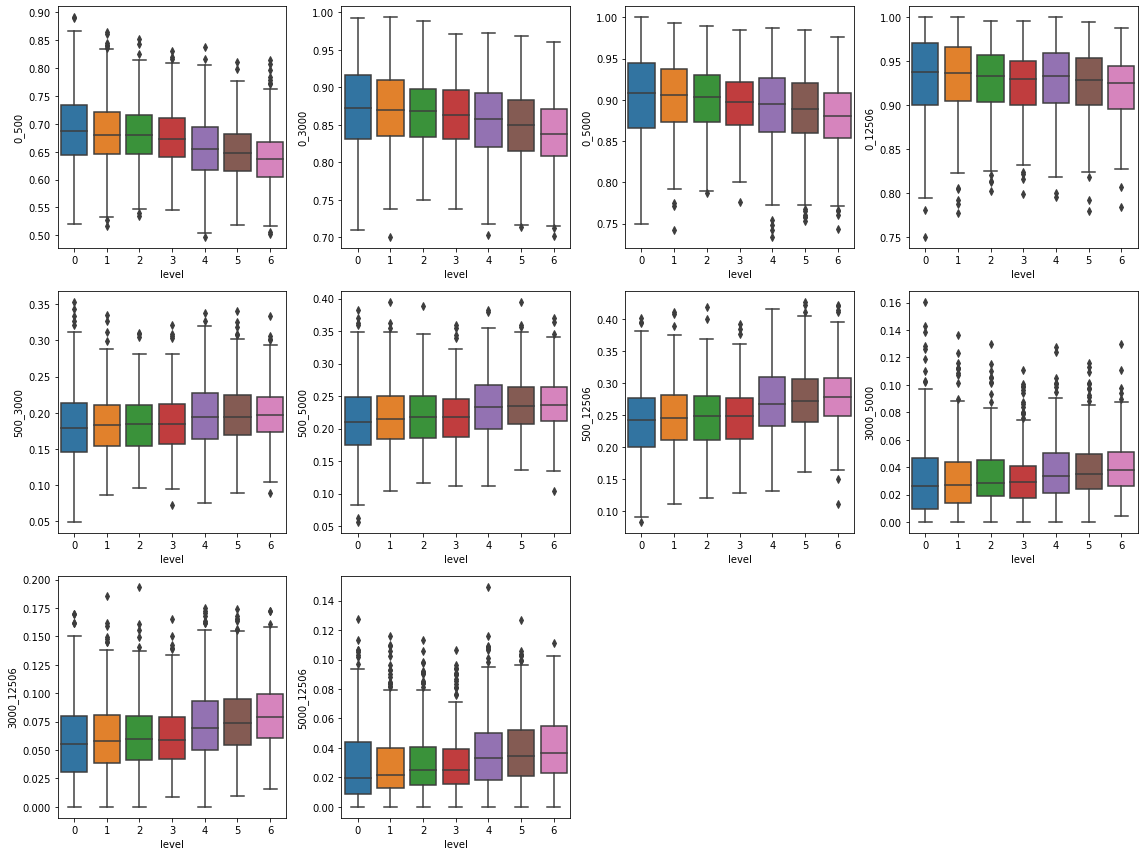

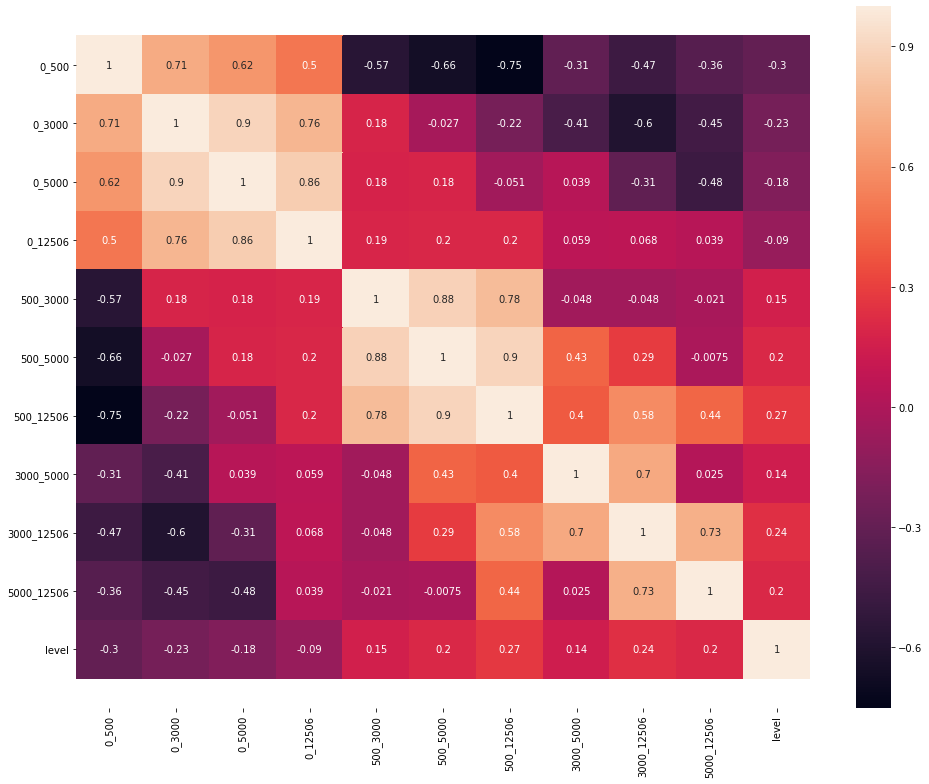

level         1.000000
500_12506     0.272200
3000_12506    0.239616
500_5000      0.203072
5000_12506    0.201896
500_3000      0.151694
3000_5000     0.139873
0_12506      -0.089699
0_5000       -0.182234
0_3000       -0.228695
0_500        -0.300955
Name: level, dtype: float64 

Dataset with 3 levels


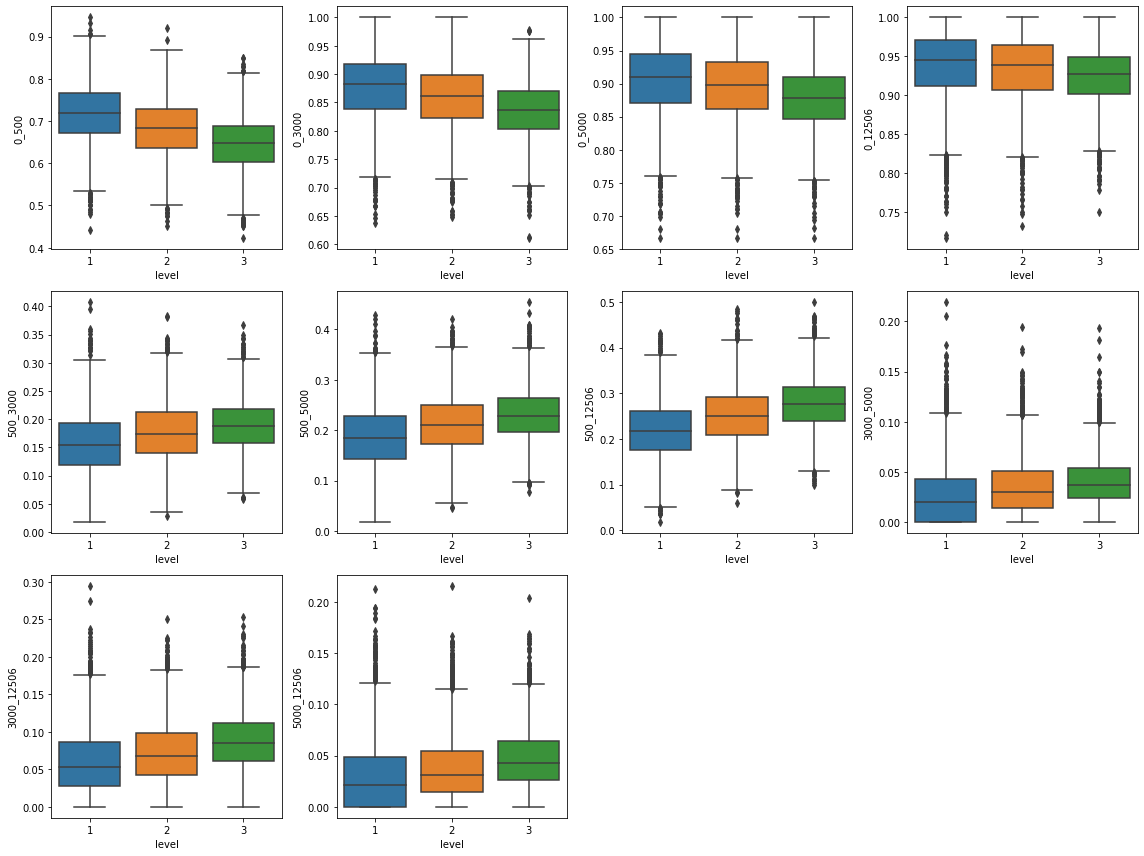

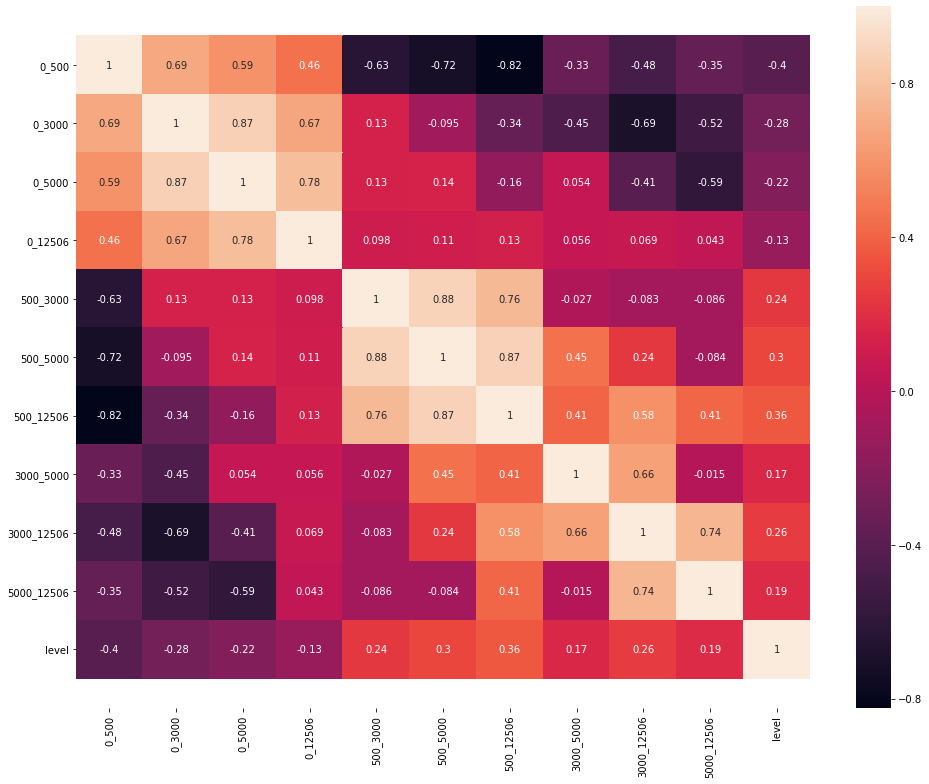

level         1.000000
500_12506     0.363791
500_5000      0.297906
3000_12506    0.255139
500_3000      0.242517
5000_12506    0.186777
3000_5000     0.171116
0_12506      -0.131100
0_5000       -0.222533
0_3000       -0.284149
0_500        -0.400697
Name: level, dtype: float64 



In [0]:
for df_name, df in datasets.items():
    print(df_name)
    frequency_parts = []

    for i_start in range(len(indices[:-1])):
        for i_end in range(i_start+1, len(indices)):
            column_name = str(indices[i_start])+'_'+str(indices[i_end])
            frequency_parts.append(column_name)
            frequency_list_part = set(frequency_wordlist[indices[i_start]:indices[i_end]])
            df[column_name] = df['lemmas'].apply(lambda x: len([w for w in x if w in frequency_list_part])/len(x))

    visualize(df, df_name, frequency_parts, 'vocab freq')

- для обоих датасетов самая большая положительная корреляция наблюдается для диапазона 500 - 12506 (7 уровней - 0.272200, 3 уровня - 0.363791)
- самая большая отрицательная корреляция - для диапазона 0 - 500 (7 уровней - -0.300955, 3 уровня - -0.400697)

### Morphology and Syntax

Функция, заменяющая токены на части речи, к которым они относятся:

In [0]:
def pos(x):
    return ' '.join([token.pos_ for token in x])

Функция, заменяющая токены на их морфологические тэги:

In [0]:
def tag(x):
    return ' '.join([token.tag_ for token in x])

Функция, заменяющая токены на синтаксические зависимости между токеном и его вершиной:

In [0]:
def dep(x):
    return ' '.join([token.dep_ for token in x])

Функция, заменяющая каждый токен на биграмму из:
- части речи, к которой относится вершина
- части речи, к которой относится сам токен

In [0]:
def pos_pos(x):
    return ' '.join(['_'.join([token.head.pos_, token.pos_]) for token in x])

Функция, заменяющая каждый токен на триграмму из:
- части речи, к которой относится вершина
- типа синтаксической зависимости между токеном и его вершиной
- части речи, к которой относится сам токен

In [0]:
def pos_dep_pos(x):
    return ' '.join(['_'.join([token.head.pos_, token.dep_, token.pos_]) for token in x])

Функция, вычисляющая среднее количество зависимых слов у токена:

In [0]:
def mean_num_dependencies(x):
     num_dependencies = [len(list(token.children)) for token in x]
     return sum(num_dependencies)/len(x)

Функция, вычисляющая среднее количество noun_chunks:

In [0]:
def num_noun_chunks(x):
    return len(list(x.noun_chunks))/len(x)

Функция, вычисляющая среднюю длину noun_chunks:

In [0]:
def length_noun_chunks(x):
    noun_chunks = list(x.noun_chunks)
    len_noun_chunks = [len(noun_chunk) for noun_chunk in noun_chunks]
    return sum(len_noun_chunks)/len(noun_chunks)

In [0]:
def activeness(x):
    x = x.split()
    active = len([dep for dep in x if dep in ('aux', 'csubj', 'nsubj')])
    passive = len([dep for dep in x if dep in ('aux_pass', 'csubjpass', 'nsubjpass')])
    
    if passive + active > 0:
        result = active / (active + passive)
    else:
        result = 0
    return result

Функция, которая вычисляет долю существительных с суффиксами, часто являющимися показателями абстрактности, от общего количества существительных:

In [0]:
reg_exp = re.compile('(?:.+)(?:ion|ment|ism|ity|ship|ness|nce|th|hood|cy|ry)')

In [0]:
def noun_abstract_suffixes(x):
    nouns = [token.lemma_.lower() for token in x if token.pos_ == 'NOUN']
    abstract_nouns = [noun for noun in nouns if re.fullmatch(reg_exp, noun)] 
    return len(abstract_nouns)/len(nouns)

Dataset with 7 levels


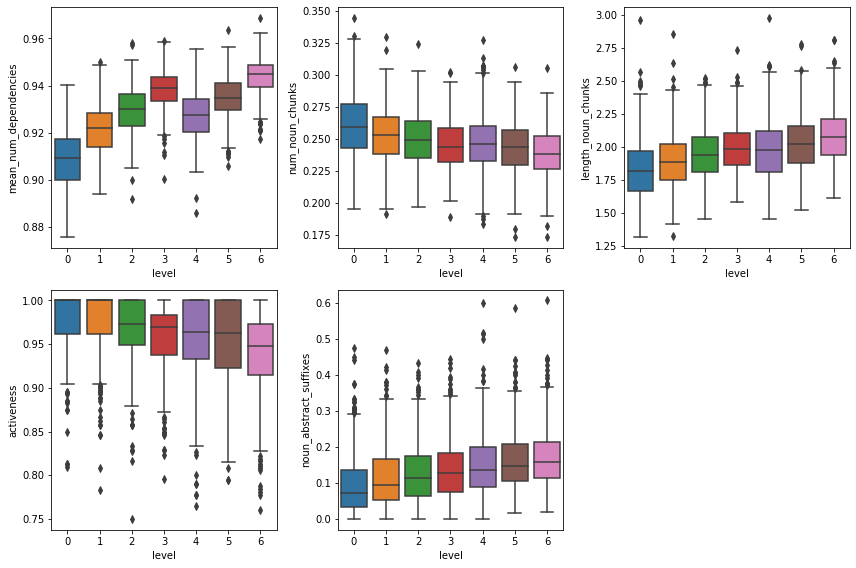

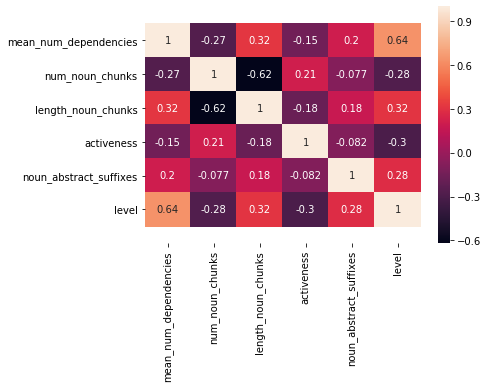

level                     1.000000
mean_num_dependencies     0.636957
length_noun_chunks        0.316028
noun_abstract_suffixes    0.281582
num_noun_chunks          -0.277018
activeness               -0.301136
Name: level, dtype: float64 

Dataset with 3 levels


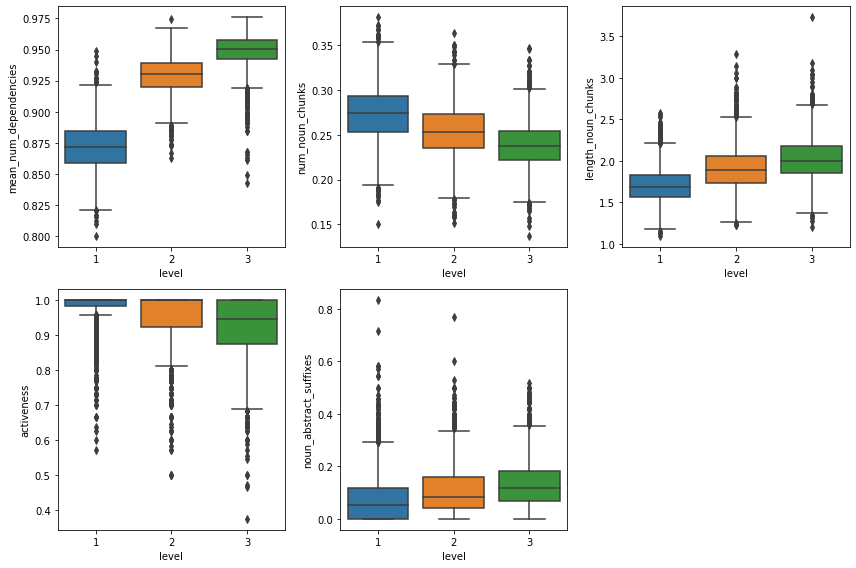

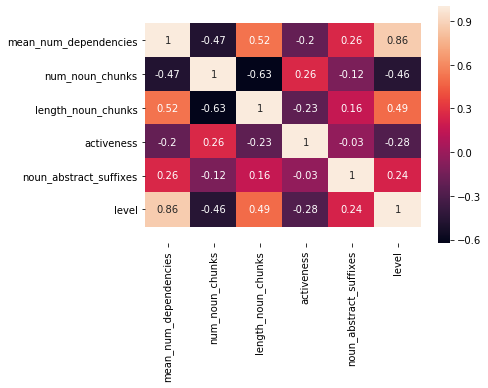

level                     1.000000
mean_num_dependencies     0.863770
length_noun_chunks        0.492544
noun_abstract_suffixes    0.235732
activeness               -0.279591
num_noun_chunks          -0.460062
Name: level, dtype: float64 



In [0]:
morphology_syntax = ['mean_num_dependencies', 'num_noun_chunks', 'length_noun_chunks', 'activeness', 'noun_abstract_suffixes']

for df_name, df in datasets.items():
    print(df_name)
    for f_name, f in {'pos': pos, 'tag': tag, 'dep': dep,
              'pos_pos': pos_pos, 'pos_dep_pos': pos_dep_pos,
              'mean_num_dependencies': mean_num_dependencies, 'num_noun_chunks': num_noun_chunks, 
              'length_noun_chunks': length_noun_chunks, 'noun_abstract_suffixes': noun_abstract_suffixes}.items():   
        df[f_name] = df['tokens'].apply(f)
    df['activeness'] = df['dep'].apply(activeness)
    
    visualize(df, df_name, morphology_syntax, 'morphology syntax')                   

# Classification

In [0]:
!pip install mord

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import mord
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectFromModel

Функция для разбиения данных на тренировочную и тестовую выборку:

In [0]:
def split_data(df):
    y = df['level']
    X = df.drop(columns=['level'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)                                                          
    print('X_train: {}\nX_test: {}\ny_train: {}\ny_test: {}'.format(
        X_train.shape, X_test.shape, y_train.shape, y_test.shape))
    return X_train, X_test, y_train, y_test

Функция, которая определяет accuracy и f1 macro:

In [0]:
def quality(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print('Accuracy: {:.4f}\nF1 macro: {:.4f}'.format(acc, f1))
    return acc, f1

Функция, строящая confusion matrix для ошибок модели:

In [0]:
def plot_confusion_matrix(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    df_cm = pd.DataFrame(cm)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Напишем функцию, которая:

- применяет масштабирование для моделей, не использующих деревья 
- производит отбор признаков на основе их важности, определяемой моделью
- выполняет классификацию
- выводит показатели качества для тренировочной (accuracy, f1 macro) и для тестовой выборок (accuracy, f1 macro, confusion matrix)

In [0]:
def classifier(clf_name, clf, X_train, X_test, y_train, y_test):

    # масштабирование признаков
    scaler = MaxAbsScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # отбор признаков на основе их важности, определяемой моделью
    selector = SelectFromModel(estimator=clf)
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)
   
    print('\n' + clf_name)
    print('Размерности после отбора признаков: X_train: {}, X_test: {}'.format(X_train.shape, X_test.shape))
    clf.fit(X_train, y_train)
    
    print('Качество на обучающей выборке:')
    y_pred_train = clf.predict(X_train) 
    acc, f1 = quality(y_train, y_pred_train)
        
    print('Качество на тестовой выборке:')
    y_pred_test = clf.predict(X_test) 
    acc, f1 = quality(y_test, y_pred_test)
    plot_confusion_matrix(y_test, y_pred_test)
    return acc, f1

Функция, выполняющая векторизацию признака:

In [0]:
def vectorize(X_train, X_test, y_train, feature):
    vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train[feature])
    X_test_vec = vectorizer.transform(X_test[feature])
    
    X_train_vec = X_train_vec/X_train['len_tokens'][:, None]
    X_test_vec = X_test_vec/X_test['len_tokens'][:, None]
    print('Размерности после векторизации признака {}: X_train: {}, X_test: {}'.format(feature, X_train_vec.shape, X_test_vec.shape))
    return X_train_vec, X_test_vec

Функция для конкатенации признаков:

In [0]:
def hstack_features(X_train_features, X_test_features):
    X_train = hstack(X_train_features)
    X_test = hstack(X_test_features)
    print('Размерности после конкатенации признаков: X_train: {}, X_test: {}'.format(X_train.shape, X_test.shape))
    return X_train, X_test

Используемые классификаторы:

In [0]:
lr1 = LogisticRegression(penalty='l1', solver='saga', random_state=42)
lr2 = LogisticRegression(penalty='l2', solver='saga', random_state=42)

logistic_at = mord.LogisticAT()
logistic_it = mord.LogisticIT()
original_ridge = mord.LAD()
lad = mord.LAD()
logistic_se = mord.LogisticSE()

In [0]:
classifiers = {'Logistic_regression_lasso': lr1, 'Logistic_regression_ridge': lr2,
               'Logistic_AT': logistic_at, 'Logistic_IT': logistic_it, 'Original_ridge': original_ridge,
               'LAD': lad, 'logistic_se': logistic_se,}

Классификаторы из библиотеки mord специально предназначены для работы с порядковой целевой переменной.

Функция для выполнения классификации:

In [0]:
def perform_classification(df):
    df['lemmatized'] = df['lemmas'].apply(lambda x: ' '.join(x))
    df['len_tokens'] = df['tokens'].apply(lambda x: len(x))
    X_train, X_test, y_train, y_test = split_data(df)
    train_for_hstack, test_for_hstack = [], []

    for feature in ['lemmatized', 'pos', 'tag', 'dep', 'pos_pos', 'pos_dep_pos']:
        X_train_vec, X_test_vec = vectorize(X_train, X_test, y_train, feature)
        train_for_hstack.append(X_train_vec)
        test_for_hstack.append(X_test_vec)
    
    features = [*readability_indices, *word_lists, *unique_lemmas_ner, *morphology_syntax]
    train_for_hstack.append(X_train[features])
    test_for_hstack.append(X_test[features])
    X_train, X_test = hstack_features(train_for_hstack, test_for_hstack)

    for clf_name, clf in classifiers.items():
        classifier(clf_name, clf, X_train, X_test, y_train, y_test)

    return X_train, X_test, y_train, y_test

In [0]:
df3['level'] = df3['level'].map({1:0, 2:1, 3:2})

Dataset with 7 levels
X_train: (2288, 47)
X_test: (572, 47)
y_train: (2288,)
y_test: (572,)
Размерности после векторизации признака lemmatized: X_train: (2288, 10515), X_test: (572, 10515)
Размерности после векторизации признака pos: X_train: (2288, 16), X_test: (572, 16)
Размерности после векторизации признака tag: X_train: (2288, 41), X_test: (572, 41)
Размерности после векторизации признака dep: X_train: (2288, 46), X_test: (572, 46)
Размерности после векторизации признака pos_pos: X_train: (2288, 186), X_test: (572, 186)
Размерности после векторизации признака pos_dep_pos: X_train: (2288, 1016), X_test: (572, 1016)
Размерности после конкатенации признаков: X_train: (2288, 11844), X_test: (572, 11844)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Logistic_regression_lasso
Размерности после отбора признаков: X_train: (2288, 1111), X_test: (572, 1111)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Качество на обучающей выборке:
Accuracy: 0.9012
F1 macro: 0.9006
Качество на тестовой выборке:
Accuracy: 0.5857
F1 macro: 0.5813


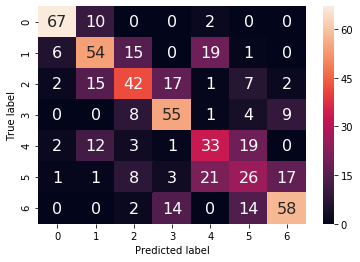

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Logistic_regression_ridge
Размерности после отбора признаков: X_train: (2288, 4151), X_test: (572, 4151)
Качество на обучающей выборке:
Accuracy: 1.0000
F1 macro: 1.0000
Качество на тестовой выборке:
Accuracy: 0.2972
F1 macro: 0.2983


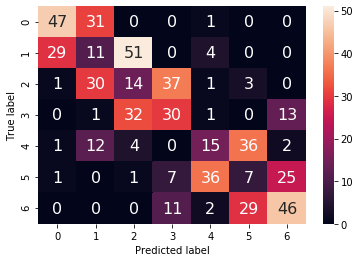


Logistic_AT
Размерности после отбора признаков: X_train: (2288, 4570), X_test: (572, 4570)
Качество на обучающей выборке:
Accuracy: 0.9891
F1 macro: 0.9891
Качество на тестовой выборке:
Accuracy: 0.6783
F1 macro: 0.6742


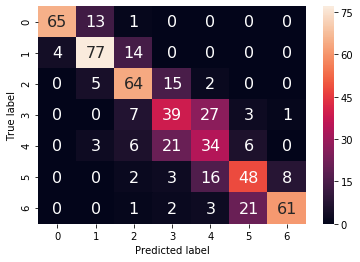


Logistic_IT
Размерности после отбора признаков: X_train: (2288, 4564), X_test: (572, 4564)
Качество на обучающей выборке:
Accuracy: 0.9830
F1 macro: 0.9831
Качество на тестовой выборке:
Accuracy: 0.6766
F1 macro: 0.6716


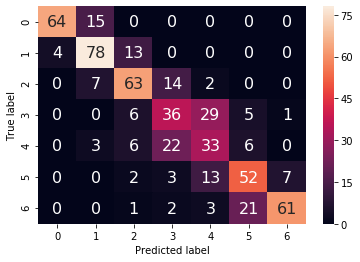


Original_ridge
Размерности после отбора признаков: X_train: (2288, 4717), X_test: (572, 4717)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Качество на обучающей выборке:
Accuracy: 1.0000
F1 macro: 1.0000
Качество на тестовой выборке:
Accuracy: 0.6731
F1 macro: 0.6723


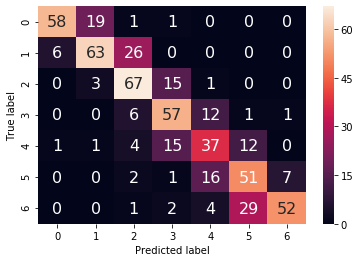


LAD
Размерности после отбора признаков: X_train: (2288, 4717), X_test: (572, 4717)
Качество на обучающей выборке:
Accuracy: 1.0000
F1 macro: 1.0000
Качество на тестовой выборке:
Accuracy: 0.6731
F1 macro: 0.6723


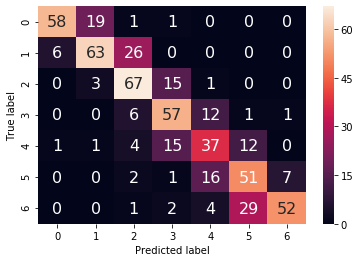


logistic_se
Размерности после отбора признаков: X_train: (2288, 4579), X_test: (572, 4579)
Качество на обучающей выборке:
Accuracy: 0.9917
F1 macro: 0.9917
Качество на тестовой выборке:
Accuracy: 0.6836
F1 macro: 0.6810


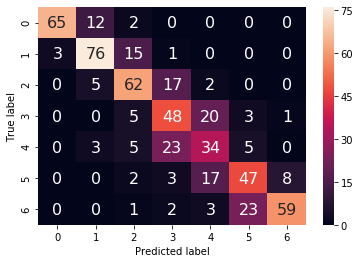


Dataset with 3 levels
X_train: (5995, 47)
X_test: (1499, 47)
y_train: (5995,)
y_test: (1499,)
Размерности после векторизации признака lemmatized: X_train: (5995, 14159), X_test: (1499, 14159)
Размерности после векторизации признака pos: X_train: (5995, 16), X_test: (1499, 16)
Размерности после векторизации признака tag: X_train: (5995, 41), X_test: (1499, 41)
Размерности после векторизации признака dep: X_train: (5995, 46), X_test: (1499, 46)
Размерности после векторизации признака pos_pos: X_train: (5995, 215), X_test: (1499, 215)
Размерности после векторизации признака pos_dep_pos: X_train: (5995, 1365), X_test: (1499, 1365)
Размерности после конкатенации признаков: X_train: (5995, 15866), X_test: (1499, 15866)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Logistic_regression_lasso
Размерности после отбора признаков: X_train: (5995, 597), X_test: (1499, 597)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Качество на обучающей выборке:
Accuracy: 0.9578
F1 macro: 0.9578
Качество на тестовой выборке:
Accuracy: 0.9066
F1 macro: 0.9065


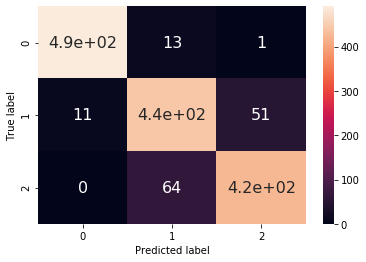

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Logistic_regression_ridge
Размерности после отбора признаков: X_train: (5995, 5326), X_test: (1499, 5326)
Качество на обучающей выборке:
Accuracy: 0.9987
F1 macro: 0.9987
Качество на тестовой выборке:
Accuracy: 0.9059
F1 macro: 0.9059


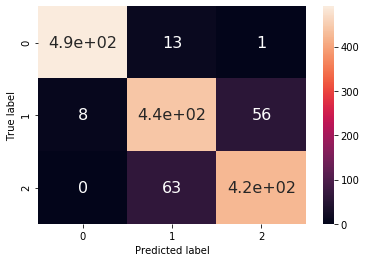


Logistic_AT
Размерности после отбора признаков: X_train: (5995, 5276), X_test: (1499, 5276)
Качество на обучающей выборке:
Accuracy: 0.9878
F1 macro: 0.9878
Качество на тестовой выборке:
Accuracy: 0.9039
F1 macro: 0.9041


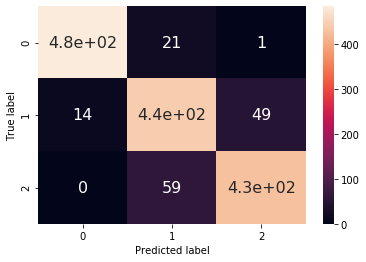


Logistic_IT
Размерности после отбора признаков: X_train: (5995, 5279), X_test: (1499, 5279)
Качество на обучающей выборке:
Accuracy: 0.9880
F1 macro: 0.9880
Качество на тестовой выборке:
Accuracy: 0.9039
F1 macro: 0.9041


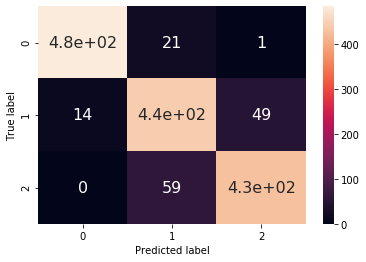

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Original_ridge
Размерности после отбора признаков: X_train: (5995, 5995), X_test: (1499, 5995)
Качество на обучающей выборке:
Accuracy: 0.9963
F1 macro: 0.9963
Качество на тестовой выборке:
Accuracy: 0.8065
F1 macro: 0.8087


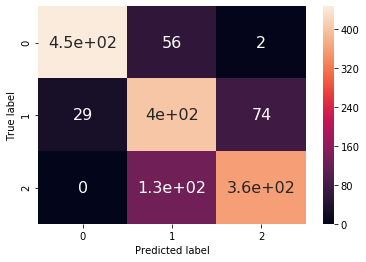


LAD
Размерности после отбора признаков: X_train: (5995, 5994), X_test: (1499, 5994)
Качество на обучающей выборке:
Accuracy: 0.9963
F1 macro: 0.9963
Качество на тестовой выборке:
Accuracy: 0.8072
F1 macro: 0.8091


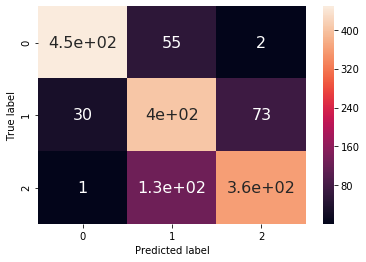


logistic_se
Размерности после отбора признаков: X_train: (5995, 5271), X_test: (1499, 5271)
Качество на обучающей выборке:
Accuracy: 0.9878
F1 macro: 0.9878
Качество на тестовой выборке:
Accuracy: 0.9039
F1 macro: 0.9041


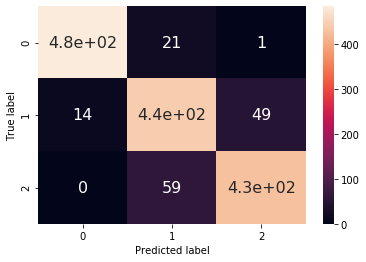

In [0]:
for df_name, df in datasets.items():
    print(df_name)
    perform_classification(df)
    print()